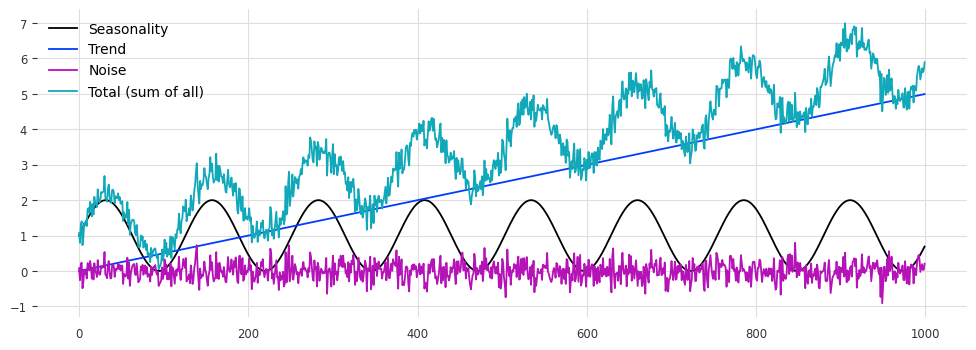

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.utils.utils import ModelMode
from darts.utils.callbacks import TFMProgressBar
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf, stationarity_tests, extract_trend_and_seasonality
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler, Diff
from darts.models import *

plt.rcParams['figure.figsize'] = (12, 4)

data_size = 1000
rng = np.random.default_rng(42)
df = pd.DataFrame({
    'seasonality': 1 + np.sin(np.arange(data_size)*.05),
    'trend': np.arange(data_size)*.005,
    'noise': rng.normal(scale=0.25, size=data_size),
})
df['total'] = df['seasonality'] + df['trend'] + df['noise']
plt.plot(df['seasonality'], label='Seasonality')
plt.plot(df['trend'], label='Trend')
plt.plot(df['noise'], label='Noise')
plt.plot(df['total'], label='Total (sum of all)')
plt.legend()
plt.show()

# Convert dataframe to time series
series = TimeSeries.from_dataframe(df)

# Define the hierarchy to the data 
series = series.with_hierarchy({
    'seasonality': ['total'],
    'trend': ['total'],
    'noise': ['total'],
 })

# Split data
train, test = series.split_after(0.75)

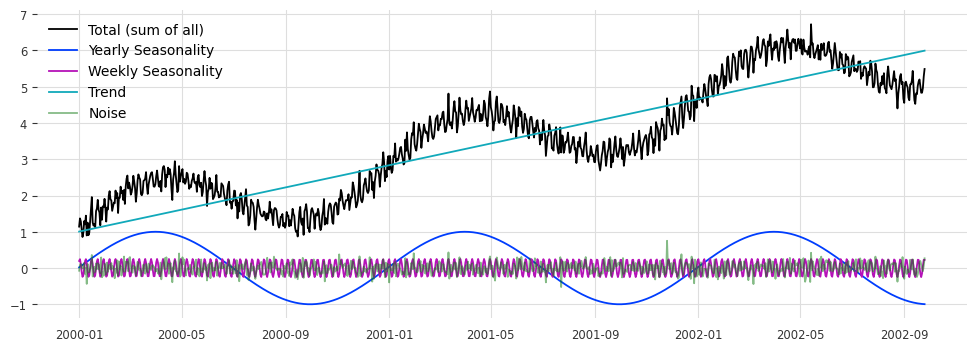

In [132]:
t = np.arange(1, data_size)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 1+t*.005,
    'noise': rng.normal(scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

plt.plot(df['total'], label='Total (sum of all)')
plt.plot(df['yearly_seasonality'], label='Yearly Seasonality')
plt.plot(df['weekly_seasonality'], label='Weekly Seasonality')
plt.plot(df['trend'], label='Trend')
plt.plot(df['noise'], label='Noise', alpha=.5)
plt.legend()
plt.show()

# Convert dataframe to time series
series = TimeSeries.from_dataframe(df)

# Define the hierarchy to the data 
series = series.with_hierarchy({
    'yearly_seasonality': ['total'],
    'weekly_seasonality': ['total'],
    'trend': ['total'],
    'noise': ['total'],
 })

# Split data
train, test = series.split_after(0.75)

### Hierarchical time series 
[Textbook example](https://otexts.com/fpp3/hts.html#hierarchical-time-series)

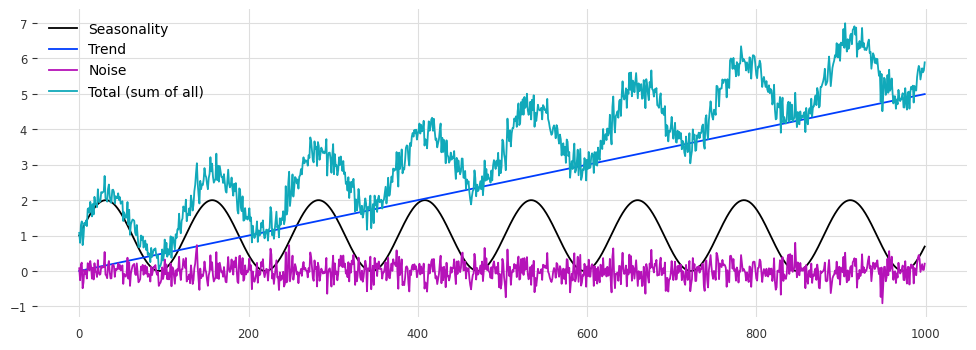

In [146]:
# df2 = pd.DataFrame({
#     'seasonality': 1 + np.cos(np.arange(data_size)*.05),
#     'trend': np.arange(data_size)**.25,
#     'noise': rng.lognormal(mean=0., sigma=.25, size=data_size),
# })
# df2['total'] = df2['seasonality'] + df2['trend'] + df2['noise']
# plt.plot(df2['seasonality'], label='Seasonality')
# plt.plot(df2['trend'], label='Trend')
# plt.plot(df2['noise'], label='Noise')
# plt.plot(df2['total'], label='Total (sum of all)')
# plt.legend()
# plt.show()

## Stationary
A time series is stationary if it does not exhibit any long term trends or obvious seasonality.
- constant variance through time
- constant mean through time

Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trends. This can also remove seasonality, if differences are taken appropriately (e.g. differencing observations 1 year apart to remove a yearly trend).

### Augmented Dickey-Fuller
We can use the Augmented Dickey-Fuller (ADF) test to test if the data is stationary. A p-value below 0.05 and a test statistic less than the critical value at the 5% significance level, indicates that the data is stationary at the 5% significance level.

In [165]:
def print_adf_results(adf_test):
    test_statistic, p_value, used_lag, nobs, critical_values, icbest = adf_test
    print(f"Test Statistic: {test_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"Number of Lags Used: {used_lag}")
    # print(f"Number of Observations: {nobs}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"    {key}: {value:.4f}")
    print(f"Maximized Information Criterion: {icbest:.4f}")
    
    

print_adf_results(stationarity_test_adf(train[['total']], maxlag=365))
print('\nWith differencing:')
print_adf_results(stationarity_test_adf(train[['total']].diff(), maxlag=365))
print('\nWith log-transform and differencing:')
print_adf_results(stationarity_test_adf(train[['total']].map(np.log).diff(), maxlag=365))

Test Statistic: 1.0668
P-Value: 0.9949
Number of Lags Used: 364
Critical Values:
    1%: -3.4475
    5%: -2.8691
    10%: -2.5708
Maximized Information Criterion: -580.3387

With differencing:
Test Statistic: -0.6299
P-Value: 0.8641
Number of Lags Used: 365
Critical Values:
    1%: -3.4476
    5%: -2.8691
    10%: -2.5708
Maximized Information Criterion: -665.8895

With log-transform and differencing:
Test Statistic: -0.7067
P-Value: 0.8450
Number of Lags Used: 365
Critical Values:
    1%: -3.4476
    5%: -2.8691
    10%: -2.5708
Maximized Information Criterion: -1669.3748


In [ ]:
# Double test on stationarity using both Kwiatkowski-Phillips-Schmidt-Shin and Augmented Dickey-Fuller statistical tests.
stationarity_tests(train[['total']])

### ACF (Autocorrelation Function) 
ACF measures the correlation between the time series and its lagged values. 

ACF is useful for identifying **MA (Moving Average)** components in time series models. If the ACF cuts off after a certain lag (e.g., drops to zero), it suggests that the series can be modeled by an MA process up to that lag.

Docs: [plot_acf](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=plot_acf#darts.utils.statistics.plot_acf)

### PACF (Partial Autocorrelation Function)
PACF measures the correlation between the time series and its lagged values, **but removes the influence of intermediate lags**.

It provides the pure or "partial" correlation at each lag, controlling for the effects of previous lags.

PACF is useful for identifying **AR (Autoregressive)** components. A cut-off in the PACF indicates the order of the AR model to use (i.e., how many past terms are needed to explain the current observation).

There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 140.
There is seasonality of order 147.


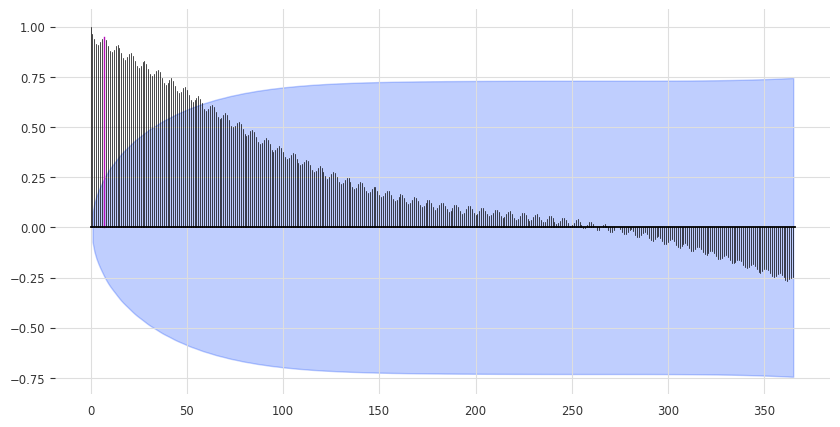

In [166]:
'''
- m (Optional[int]) – a time lag to highlight on the plot.
- max_lag (int) – maximal lag order to consider.
- alpha (float) – confidence interval to display.
'''
plot_acf(train[['total']], m=7, max_lag=365, alpha=0.05)

for m in range(25, 150):
    is_seasonal, period = check_seasonality(train[['total']], m=m, max_lag=365, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

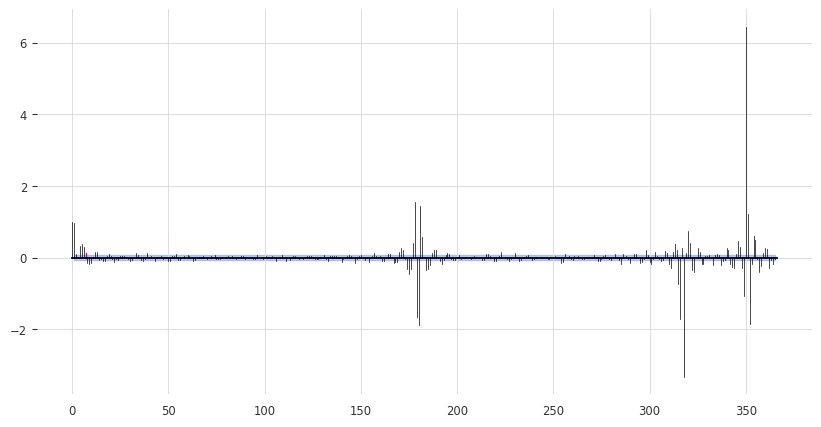

In [167]:
# plot_pacf(train[['total']], m=126, max_lag=150, alpha=0.05)
plot_pacf(train[['total']], m=7, max_lag=365, alpha=0.05)

In [160]:
# series
scaler_covariates = Scaler()

### Extract trend and seasonality

In additive seasonality, the seasonal variation is added to the underlying trend, resulting in constant seasonal changes regardless of the overall level.

In multiplicative seasonality, the seasonal component is multiplied by the trend, leading to changes in the size of the seasonal pattern as the trend increases or decreases.

STL: Season-Trend decomposition using LOESS

MSTL: Season-Trend decomposition using LOESS with multiple seasonalities

<Axes: xlabel='time'>

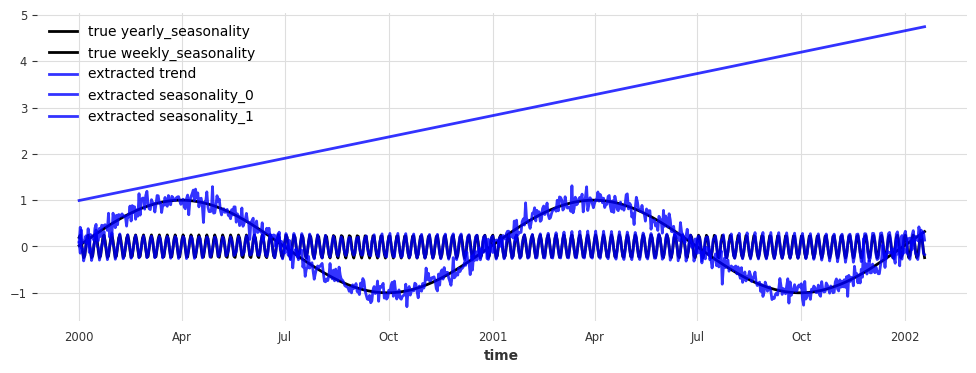

In [169]:
train[['yearly_seasonality']].plot(label='true yearly_seasonality', color='black')
train[['weekly_seasonality']].plot(label='true weekly_seasonality', color='black')

trend, seasonality = extract_trend_and_seasonality((train[['total']]), freq=[7, 365], model=ModelMode.ADDITIVE, method='MSTL')
trend.plot(label='extracted trend', color='blue', alpha=.8)
seasonality.plot(label='extracted seasonality', color='blue', alpha=.8)

<Axes: xlabel='time'>

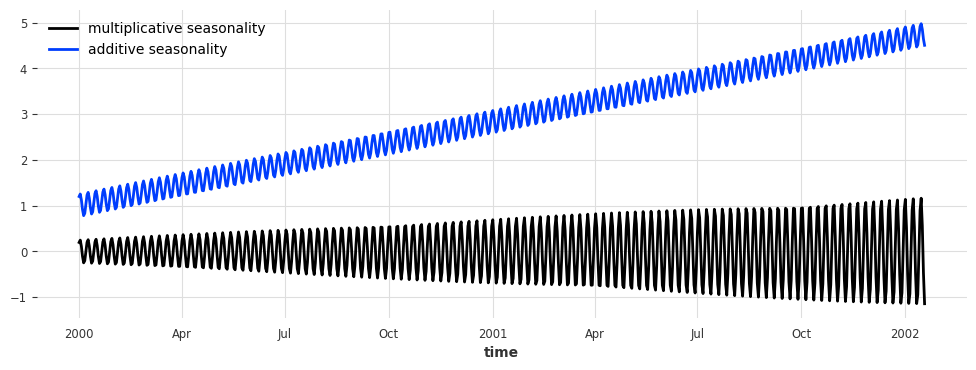

In [174]:
(train[['weekly_seasonality']] * train[['trend']]).plot(label='multiplicative seasonality')
(train[['weekly_seasonality']] + train[['trend']]).plot(label='additive seasonality')

### Naive Forecast
- NaiveSeasonal(K) "repeats" the value that occured 'K' time steps ago.
- NaiveDrift produces linear predictions, with a slope that is determined by the first and last values of the training set.

<Axes: xlabel='time'>

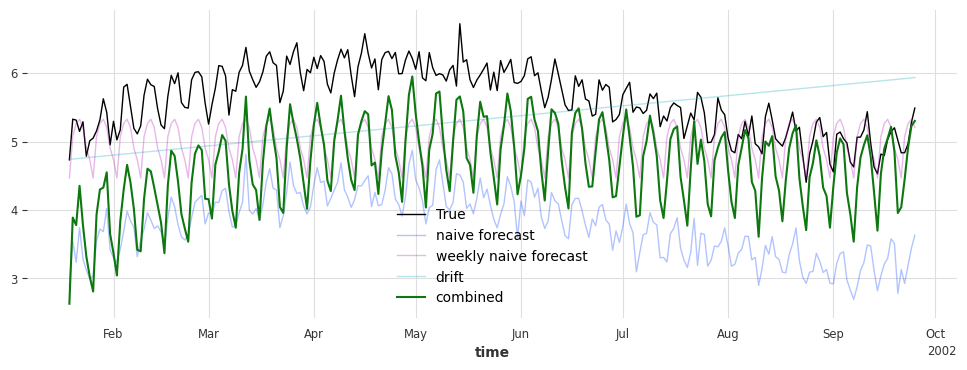

In [184]:
seasonal_model = NaiveSeasonal(K=365)
seasonal_model.fit(train[['total']])
seasonal_forecast = seasonal_model.predict(len(test))

weekly_seasonal_model = NaiveSeasonal(K=7)
weekly_seasonal_model.fit(train[['total']])
weekly_seasonal_forecast = weekly_seasonal_model.predict(len(test))

drift_model = NaiveDrift()
drift_model.fit(train[['total']])
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast + weekly_seasonal_forecast - 2*train[['total']].last_value()

# train[['total']].plot(label='True Train', linewidth=1)
test[['total']].plot(label='True', linewidth=1, alpha=1)
seasonal_forecast.plot(label="naive forecast", linewidth=1, alpha=0.3)
weekly_seasonal_forecast.plot(label="weekly naive forecast", linewidth=1, alpha=0.3)
drift_forecast.plot(label="drift", linewidth=1, alpha=0.3)
combined_forecast.plot(label="combined", linewidth=1.5)

In [190]:
# train[['total']].plot(label='Train', linewidth=1)
# MovingAverageFilter(200).filter(train[['total']]).plot(label=f'10')
# MovingAverageFilter(30).filter(train[['total']]).plot(label=f'30')
# MovingAverageFilter(126).filter(train[['total']]).plot(label=f'126')
# Diff(126)
# train[['seasonality']].plot()
# Diff(lags=1, dropna=True).fit_transform(train[['trend']]).plot()
# Diff(lags=7, dropna=True).fit_transform(train[['trend']]).plot()

In [193]:
def fit_predict_plot(model, model_name):
    model.fit(train[['total']])
    pred = model.predict(len(test))
    train[['total']].plot(label='Train', linewidth=1)
    test[['total']].plot(label='Test', linewidth=1, alpha=0.6)
    pred.plot(label=f'{model_name}', alpha=0.8)
    plt.show()
    print(f"{model_name} MAPE: {mape(test[['total']], pred):.2f}%.)")

### Exponential Smoothing

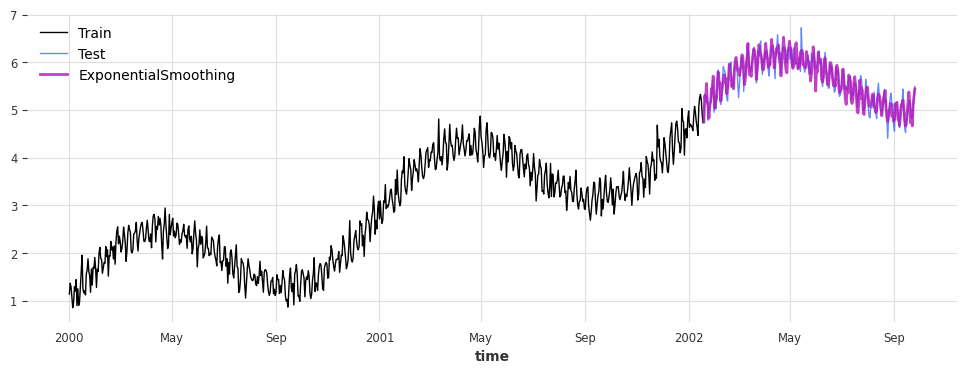

ExponentialSmoothing MAPE: 2.53%.)


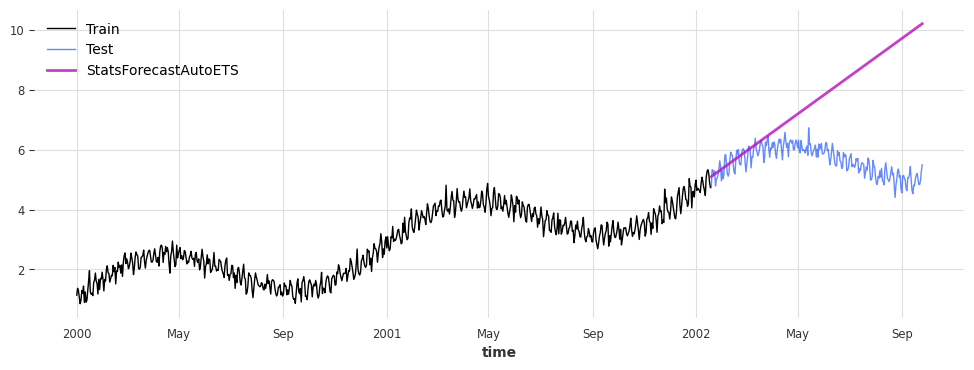

StatsForecastAutoETS MAPE: 38.99%.)


In [194]:
fit_predict_plot(ExponentialSmoothing(seasonal_periods=365), model_name='ExponentialSmoothing')
fit_predict_plot(StatsForecastAutoETS(season_length=365), model_name='StatsForecastAutoETS')

### ARIMA
[ARIMA docs](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.arima.html#darts.models.forecasting.arima.ARIMA)


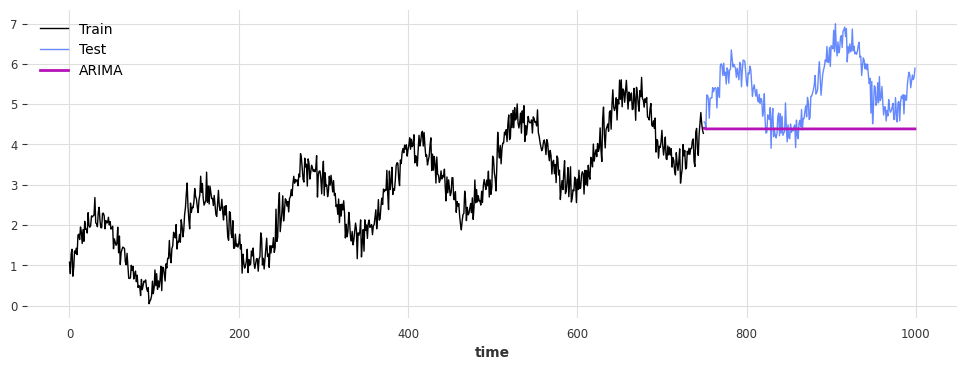

ARIMA MAPE: 17.76%.)


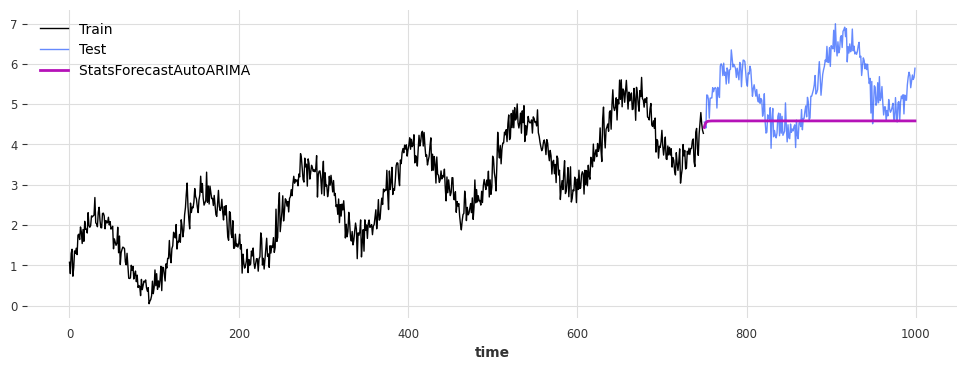

StatsForecastAutoARIMA  MAPE: 15.09%.)


In [238]:
fit_predict_plot(ARIMA(p=2, d=1, q=1), model_name='ARIMA')
# fit_predict_plot(AutoARIMA(), model_name='AutoARIMA')
fit_predict_plot(StatsForecastAutoARIMA(), model_name='StatsForecastAutoARIMA ')

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


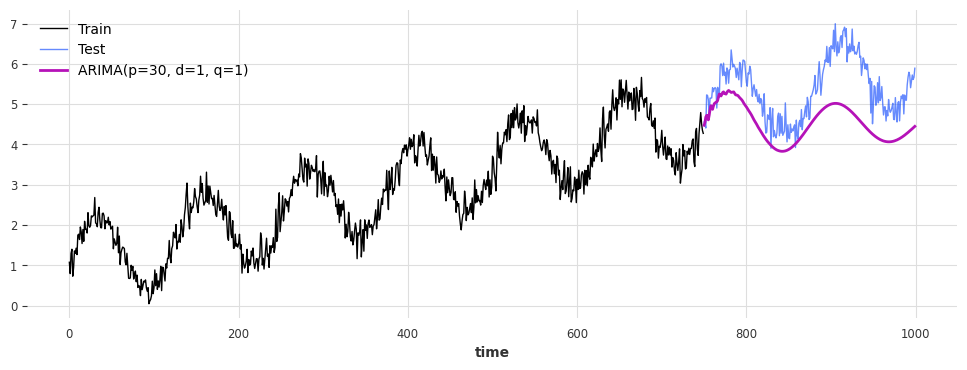

ARIMA(p=30, d=1, q=1) MAPE: 15.23%.)


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


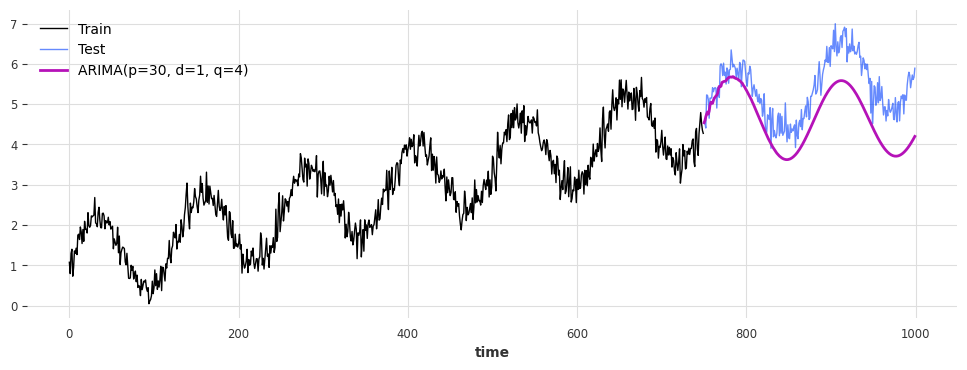

ARIMA(p=30, d=1, q=4) MAPE: 13.77%.)


In [21]:
fit_predict_plot(ARIMA(p=30, d=1, q=1), model_name='ARIMA(p=30, d=1, q=1)')
fit_predict_plot(ARIMA(p=30, d=1, q=4), model_name='ARIMA(p=30, d=1, q=4)')

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


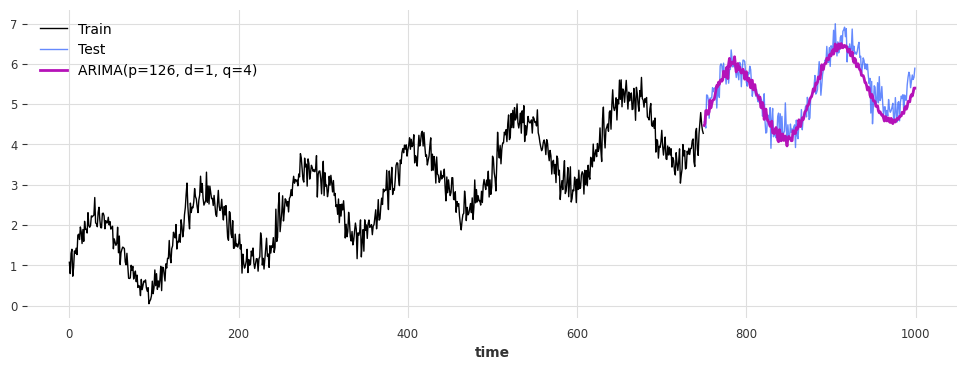

ARIMA(p=126, d=1, q=4) MAPE: 4.76%.)


In [22]:
fit_predict_plot(ARIMA(p=126, d=1, q=4), model_name='ARIMA(p=126, d=1, q=4)')

c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\JBarker\OneDrive - Generac Power Systems, Inc\Documents\Code\torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


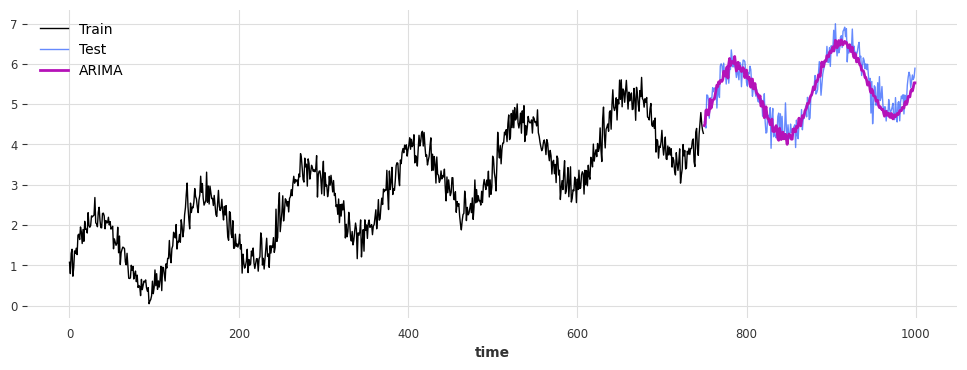

ARIMA MAPE: 4.27%.)


In [241]:
fit_predict_plot(ARIMA(p=126, d=1, q=1), model_name='ARIMA(p=126, d=1, q=1)')